In [3]:
from logging import getLogger
from logging.config import dictConfig

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAUPRC, BinaryAUROC, BinaryPrecisionRecallCurve
from yaml import safe_load

from streamvigil import CSVDataset
from streamvigil.detectors import BasicAutoEncoder, BasicDetector

In [2]:
# Logger
with open("./logging.yml", encoding="utf-8") as file:
    config = safe_load(file)
dictConfig(config)
logger = getLogger(__name__)

In [5]:
random_state = 42

# Dataset
train_data = CSVDataset(
    "../data/INSECTS/INSECTS_Abr.csv.gz",
    train=True,
    random_state=random_state,
)
test_data = CSVDataset(
    "../data/INSECTS/INSECTS_Abr.csv.gz",
    train=False,
    random_state=random_state,
)

# DataLoader
train_loader = DataLoader(
    train_data,
    batch_size=128,
)
test_loader = DataLoader(
    test_data,
    batch_size=64,
)

In [6]:
# Anomaly Detector
auto_encoder = BasicAutoEncoder(
    encoder_dims=[33, 28, 23, 18],
    decoder_dims=[18, 23, 28, 33],
    batch_norm=True,
)
detector = BasicDetector(auto_encoder)

In [7]:
# Training
epochs = 5
logger.info("Start training the model...")
for epoch in range(epochs):
    logger.info(f"Epoch: {epoch+1}")
    for batch, (X, _) in enumerate(train_loader):
        loss = detector.train(X)

        if batch % 100 == 0:
            logger.info(f"Loss: {loss.item():>7f}")
logger.info("Completed training the model!")

2024-06-05 09:57:04,432 [INFO] __main__: Start training the model...
2024-06-05 09:57:04,432 [INFO] __main__: Epoch: 1
2024-06-05 09:57:04,895 [INFO] __main__: Loss: 0.227513
2024-06-05 09:57:05,119 [INFO] __main__: Loss: 0.123720
2024-06-05 09:57:05,323 [INFO] __main__: Loss: 0.068946
2024-06-05 09:57:05,408 [INFO] __main__: Epoch: 2
2024-06-05 09:57:05,411 [INFO] __main__: Loss: 0.052431
2024-06-05 09:57:05,613 [INFO] __main__: Loss: 0.027646
2024-06-05 09:57:05,813 [INFO] __main__: Loss: 0.015600
2024-06-05 09:57:05,899 [INFO] __main__: Epoch: 3
2024-06-05 09:57:05,901 [INFO] __main__: Loss: 0.013050
2024-06-05 09:57:06,109 [INFO] __main__: Loss: 0.009227
2024-06-05 09:57:06,308 [INFO] __main__: Loss: 0.006972
2024-06-05 09:57:06,393 [INFO] __main__: Epoch: 4
2024-06-05 09:57:06,396 [INFO] __main__: Loss: 0.006869
2024-06-05 09:57:06,593 [INFO] __main__: Loss: 0.006644
2024-06-05 09:57:06,788 [INFO] __main__: Loss: 0.005120
2024-06-05 09:57:06,872 [INFO] __main__: Epoch: 5
2024-06-0

In [9]:
# Area Under the ROC Curve
auroc = BinaryAUROC()
# Area Under the Precision-Recall Curve
auprc = BinaryAUPRC()

pr_curve = BinaryPrecisionRecallCurve()

for X, y in test_loader:
    scores = detector.predict(X)
    auroc.update(scores, y)
    auprc.update(scores, y)
    pr_curve.update(scores, y)

# Compute evaluatin scores
logger.info(f"AUROC Score: {auroc.compute()}")
logger.info(f"AUPRC Score: {auprc.compute()}")

logger.info("Completed the evaluation of the model!")

2024-06-05 09:58:29,924 [INFO] __main__: AUROC Score: 0.51187241667705
2024-06-05 09:58:29,928 [INFO] __main__: AUPRC Score: 0.014189984649419785
2024-06-05 09:58:29,928 [INFO] __main__: Completed the evaluation of the model!


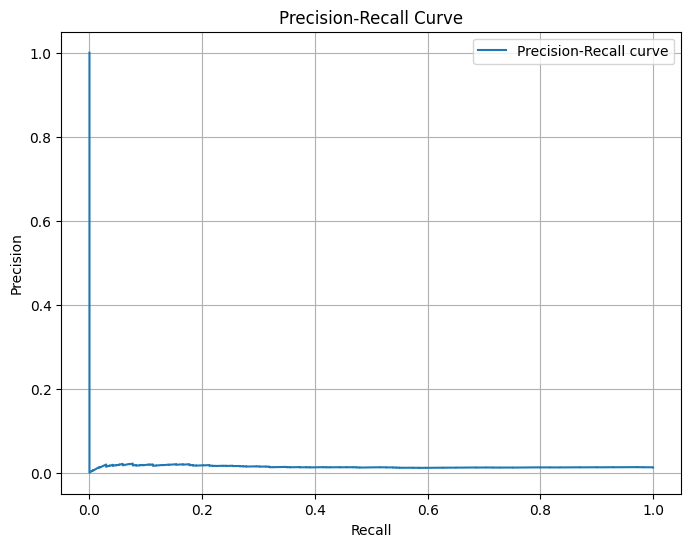

In [10]:
# Visualize Precision-Recall Curve
precision, recall, thresholds = pr_curve.compute()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()